## Clustering using KShape
- Clustering Methods in Time Series Data
- Implemented in [tslearn](https://github.com/rtavenar/tslearn)

The algorithm will be executed in the following.

1. Use a distance scale based on cross-correlation measurements (Shape-based distance: SBD)
2. Compute the center of gravity of time series clusters based on 1. (a new center-of-gravity-based clustering algorithm that preserves the shape of the time series)
3. The method of dividing the data into clusters is the same as for general kmeans, but 1. and 2. above are used when calculating the distance scale and center of gravity

Please refer to the paper for detailed formulas and theory.

[J. Paparrizos & L. Gravano. k-Shape: Efficient and Accurate Clustering of Time Series. SIGMOD 2015. pp. 1855-1870.](http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf)

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

%matplotlib inline

/Users/masataka/.pyenv/versions/anaconda3-5.3.0/envs/datascience/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def align_timeseries_dataset(dfs, target_col=None):
    # Load dataframes, turns them into a time-series array, and stores them in a list
    tsdata = []
    for i, df in enumerate(dfs):
        tsdata.append(df[target_col].values.tolist()[:])
        
        # Check the maximum length of each time series data
        len_max = 0
        for ts in tsdata:
            if len(ts) > len_max:
                len_max = len(ts)
        
        # Assign the last data to align the length of the time series data
        for i, ts in enumerate(tsdata):
            len_add = len_max - len(ts)
            tsdata[i] = ts + [ts[-1]] * len_add
    
    tsdata = np.array(tsdata)
    return tsdata

def transform_timeseries_vectors(timeseries_dataset):
    # Transform vectors
    stack_list = []
    for j in range(len(timeseries_dataset)):
        data = np.array(timeseries_dataset[j])
        data = data.reshape((1, len(data))).T
        stack_list.append(data)
    
    # Convert to one-dimensional array
    transformed_data = np.stack(stack_list, axis=0)
    return transformed_data

## Prepare for datasets

In [3]:
# Get some filelists
filenames = sorted(glob.glob('sample_data/sample_data*.csv'))

In [4]:
# Loads a dataframe from a file and stores it in a list
df_list = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)

In [5]:
dfs = align_timeseries_dataset(df_list, target_col='data')
transformed_data = transform_timeseries_vectors(dfs)

## Visualize clustering results

In [ ]:
seed = 0
np.random.seed(seed)

Init 1
0.015 --> 0.016 --> 
Init 2
Resumed because of empty cluster
Init 2
0.010 --> 0.012 --> 
Init 3
0.019 --> Resumed because of empty cluster
Init 3
0.018 --> 0.018 --> 0.018 --> 
Init 4
0.013 --> 0.013 --> 0.022 --> 
Init 5
Resumed because of empty cluster
Init 5
0.006 --> 0.010 --> 
Init 6
Resumed because of empty cluster
Init 6
0.006 --> 0.010 --> 


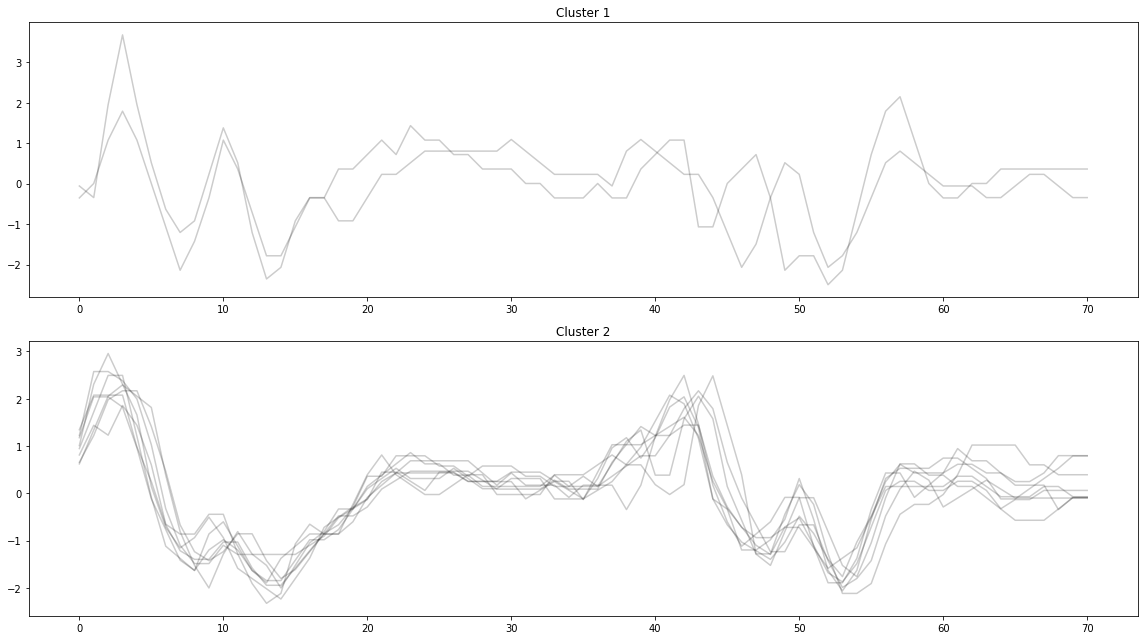

In [6]:
# To calculate the cross-correlation, it must be normalized.
# TimeSeriesScalerMeanVariance will be the class that normalizes the data.
stack_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(transformed_data)

# Instantiation of KShape class
ks = KShape(n_clusters=2, n_init=10, verbose=True, random_state=seed)
y_pred = ks.fit_predict(stack_data)

# Clustering and visualizing results
plt.figure(figsize=(16, 9))
for yi in range(2):
    plt.subplot(2, 1, 1 + yi)
    for xx in stack_data[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    # plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

## Calculation of the number of clusters using the elbow method
- What is the elbow method?
    - The sum of the squares of the distances from each point to the assigned cluster center is calculated as the sum of the squares of the within-cluster error squares (SSE).
    - クラスタ数を変えて、それぞれのSSE値をプロットし、「肘」のように曲がった点を最適なクラスタ数とする方法です。

- エルボー法について、wikipediaに記載されています。
    - [Elbow method (clustering)](https://en.wikipedia.org/wiki/Elbow_method_(clustering))

Init 1
0.023 --> 0.024 --> 
Init 2
0.022 --> 0.023 --> 
Init 3
0.022 --> 0.022 --> 0.023 --> 
Init 4
0.022 --> 0.022 --> 0.023 --> 
Init 5
0.022 --> 0.023 --> 
Init 6
0.023 --> 0.023 --> 0.033 --> 
Init 7
0.022 --> 0.022 --> 0.023 --> 
Init 8
0.023 --> 0.024 --> 
Init 9
0.023 --> 0.023 --> 
Init 10
0.027 --> 0.023 --> 0.024 --> 
Init 1
0.015 --> 0.016 --> 
Init 2
Resumed because of empty cluster
Init 2
0.010 --> 0.012 --> 
Init 3
0.019 --> Resumed because of empty cluster
Init 3
0.018 --> 0.018 --> 0.018 --> 
Init 4
0.013 --> 0.013 --> 0.022 --> 
Init 5
Resumed because of empty cluster
Init 5
0.006 --> 0.010 --> 
Init 6
Resumed because of empty cluster
Init 6
0.006 --> 0.010 --> 
Init 1
0.009 --> Resumed because of empty cluster
Init 1
0.008 --> 0.009 --> 
Init 2
0.015 --> Resumed because of empty cluster
Init 2
0.010 --> 0.009 --> 0.016 --> 
Init 3
Resumed because of empty cluster
Init 3
Resumed because of empty cluster
Init 3
0.004 --> 0.007 --> 
Init 4
Resumed because of empty clust

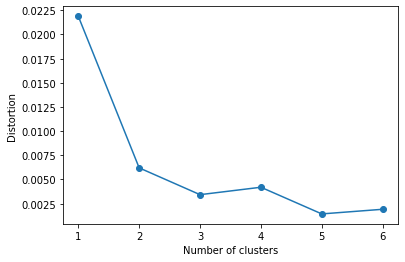

In [7]:
distortions = []

#1~10クラスタまで計算 
for i  in range(1,11):
    ks = KShape(n_clusters=i, n_init=10, verbose=True, random_state=seed)
    #クラスタリングの計算を実行
    ks.fit(stack_data)
    #ks.fitするとks.inertia_が得られる
    distortions.append(ks.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()